In [1]:
import datetime
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.models import Model

training_data_path = r"j:\LettersTraining"
testing_data_path = r"j:\LettersTesting"

model_save_path = r"j:\SavedModels"
notebook_save_path = r"J:\SavedNotebooks"

classes = ['A', 'C', 'None', 'R', 'S']

resized_image_size = 64

if not os.path.exists(training_data_path):
    print("Could not find folder: " + training_data_path)
    raise

if not os.path.exists(testing_data_path):
    print("Could not find folder: {}".format(testing_data_path))
    raise

Using TensorFlow backend.


In [2]:
from sklearn.model_selection import train_test_split

training_globs = []
testing_globs = []

num_classes = len(classes)

print("Number of classes: {}".format(num_classes))

for i in range(num_classes):
    training_class_path = os.path.join(training_data_path, classes[i])
    testing_class_path = os.path.join(testing_data_path, classes[i])
    
    training_class_glob = glob(os.path.join(training_class_path, "*.png"))
    testing_class_glob = glob(os.path.join(testing_class_path, "*.png"))
    
    training_globs.append(training_class_glob)
    testing_globs.append(testing_class_glob)

Number of classes: 5


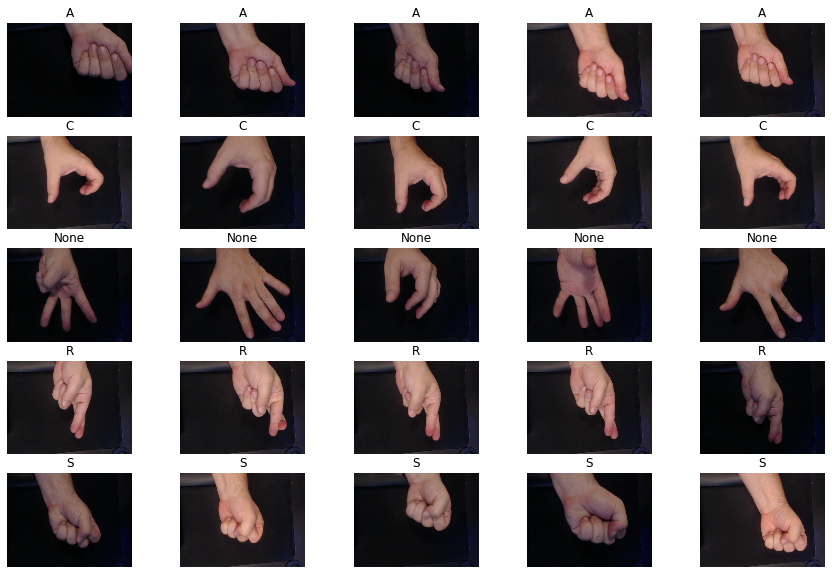

In [3]:
# Show sample images of all classes

num_choices = 5
random_choices = []
labels = []

for i in range(num_classes):
    random_choice = np.random.choice(training_globs[i], num_choices)
    random_choices.append(random_choice)
    labels.append(num_choices * [classes[i]])

plt.figure(figsize=(3*num_choices,2*num_classes))

for class_index in range(num_classes):
    for choice_index in range(num_choices):
        im = Image.open(random_choices[class_index][choice_index]).convert('RGB')
        plt.subplot(num_classes, num_choices, class_index * num_choices + choice_index + 1)
        plt.title(labels[class_index][choice_index])
        plt.imshow(np.asarray(im))
        plt.axis('off')

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    training_data_path,
    target_size=(resized_image_size, resized_image_size),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = train_datagen.flow_from_directory(
    testing_data_path,
    target_size=(resized_image_size, resized_image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 3274 images belonging to 5 classes.
Found 230 images belonging to 5 classes.


In [5]:
def HappyModel():
    X_input = Input(shape = (resized_image_size, resized_image_size, 3), name = 'X_input')
 
    X = Conv2D(8, (3, 3), strides = (1,1) , padding = 'valid')(X_input)
    X = MaxPooling2D(pool_size = (2, 2))(X)
 
    X = Conv2D(16, (3, 3), strides = (1,1) , padding = 'valid')(X)
    X = Conv2D(32, (3, 3), strides = (1,1) , padding = 'valid')(X)
    X = MaxPooling2D(pool_size = (2, 2))(X)
    
    X = Conv2D(64, (3, 3), strides = (1,1) , padding = 'valid')(X)
    X = Conv2D(128, (3, 3), strides = (1,1) , padding = 'valid')(X)
    X = MaxPooling2D(pool_size = (2, 2))(X)
 
    X = Flatten()(X)

    X = Dense(num_classes * 8 + 20, input_shape = (29 * 29 * 16, 1))(X)
    X = Activation('relu')(X)
    X = Dropout(0.4)(X)
 
    X = Dense(num_classes * 4 + 10)(X)
    X = Activation('relu')(X)
 
    X = Dense(num_classes)(X)
    X = Activation('softmax')(X)
    
    return Model([X_input], [X])

model = HappyModel()

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxP

In [6]:
num_epochs = 30
steps_per_epoch = int(train_generator.n / batch_size)
validation_steps = int(test_generator.n / batch_size)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

training_time_start = datetime.datetime.now()

history = model.fit_generator(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
102/102 [==============================] - 25s 250ms/step - loss: 0.4389 - acc: 0.8105 - val_loss: 0.3355 - val_acc: 0.8455
Epoch 2/30
102/102 [==============================] - 24s 240ms/step - loss: 0.3057 - acc: 0.8670 - val_loss: 0.2323 - val_acc: 0.8848
Epoch 3/30
102/102 [==============================] - 25s 242ms/step - loss: 0.2551 - acc: 0.8903 - val_loss: 0.1998 - val_acc: 0.8919
Epoch 4/30
102/102 [==============================] - 25s 247ms/step - loss: 0.2129 - acc: 0.9067 - val_loss: 0.1809 - val_acc: 0.9273
Epoch 5/30
102/102 [==============================] - 26s 259ms/step - loss: 0.2011 - acc: 0.9153 - val_loss: 0.1378 - val_acc: 0.9525
Epoch 6/30
102/102 [==============================] - 24s 239ms/step - loss: 0.1724 - acc: 0.9327 - val_loss: 0.1127 - val_acc: 0.9576
Epoch 7/30
102/102 [==============================] - 27s 269ms/step - loss: 0.1687 - acc: 0.9360 - val_loss: 0.1273 - val_acc: 0.9465
Epoch 8

In [7]:
training_time_stop = datetime.datetime.now()
print("Training started at: {}".format(training_time_start))
print("Training stopped at: {}".format(training_time_stop))
print("Total training time: {}".format(training_time_stop-training_time_start))

Training started at: 2019-06-10 20:20:11.344703
Training stopped at: 2019-06-10 20:33:24.666321
Total training time: 0:13:13.321618


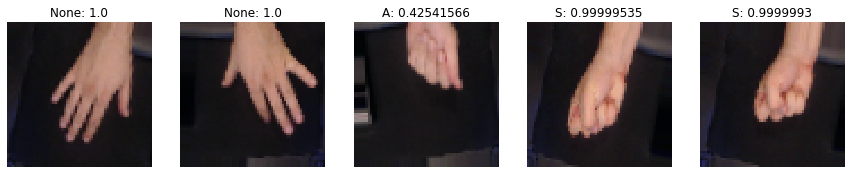

In [8]:
test_generator.reset()
x,y = test_generator.next()

num_choices = 5
test_indices = range(batch_size)

random_choice = np.random.choice(test_indices, num_choices)

plt.figure(figsize=(3*num_choices, 3))

for i in range(num_choices):
    im = x[random_choice[i]][:,:,:]
    prediction = model.predict(np.expand_dims(im, 0))
    plt.subplot(1, num_choices, i+1)
    max_index = np.argmax(prediction[0])
    plt.title(str(classes[max_index]) + ": " + str(prediction[0][max_index]))
    plt.imshow((im + 1)/2)
    plt.axis('off')

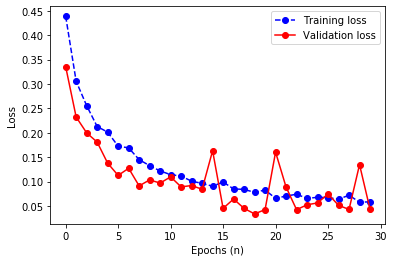

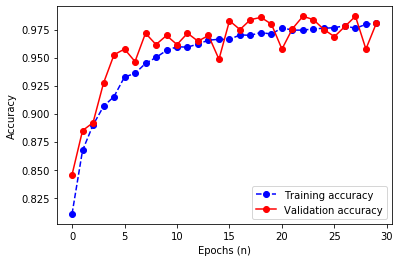

In [9]:
plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'], 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training loss', 'Validation loss'])
plt.show()
plt.plot(history.history['acc'], 'bo--')
plt.plot(history.history['val_acc'], 'ro-')
plt.ylabel('Accuracy')
plt.xlabel('Epochs (n)')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

In [10]:
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)
    print("Creating folder: {}".format(model_save_path))

model_file_name = "model_" + timestamp + ".h5"
model_file_fullname = os.path.join(model_save_path, model_file_name)

model.save(model_file_fullname)
print("Model saved to: {}".format(model_file_fullname))

notebook_file_name = "notebook_" + timestamp + ".html"
notebook_file_fullpath = os.path.join(notebook_save_path, notebook_file_name)

if not os.path.exists(notebook_save_path):
    os.makedirs(notebook_save_path)
    print("Creating folder: {}".format(notebook_save_path))

os.system("jupyter nbconvert --to html TrainHappyModel.ipynb --output " + notebook_file_fullpath)

print("Notebook saved to: {}".format(notebook_file_fullpath))

Model saved to: j:\SavedModels\model_2019-06-10_20-33-25.h5
Notebook saved to: J:\SavedNotebooks\notebook_2019-06-10_20-33-25.html
